# Mirror Descent Convergence Analysis

This notebook visualizes how the mirror descent algorithm converges during optimization of the Wasserstein distance computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from test_utils import test_sparse_mirror_descent, test_ws_distance, dia_matrix

## Run Mirror Descent Optimization

First, we'll run the optimization with different parameters and collect the convergence data.

In [ ]:
# Define parameters
N = 2000        # Number of features
C = 15         # Bandwidth parameter
p = 0.4       # Mixing ratio
reg = 1.5    # KL regularization
reg_a = 150     # Source marginal regularization 
reg_b = 150    # Target marginal regularization
max_iter = 1000  # Maximum iterations
step_size = 0.00001  # Learning rate
gamma = 1.0 - 1.0 / max_iter

# Run optimization
_, log_data = test_sparse_mirror_descent(
    N, C, p, reg, reg_a, reg_b, 
    max_iter=max_iter, 
    step_size=step_size, 
    debug=False,
    gamma=gamma,
)

print(f"Optimization completed in {log_data.get('iterations', 'unknown')} iterations")
print(f"Converged: {log_data.get('convergence', False)}")
print(f"Final objective value: {log_data.get('final_distance', 'unknown')}")

Optimization completed in 311 iterations
Converged: True
Final objective value: 0.9489506355950461


## Visualize Convergence


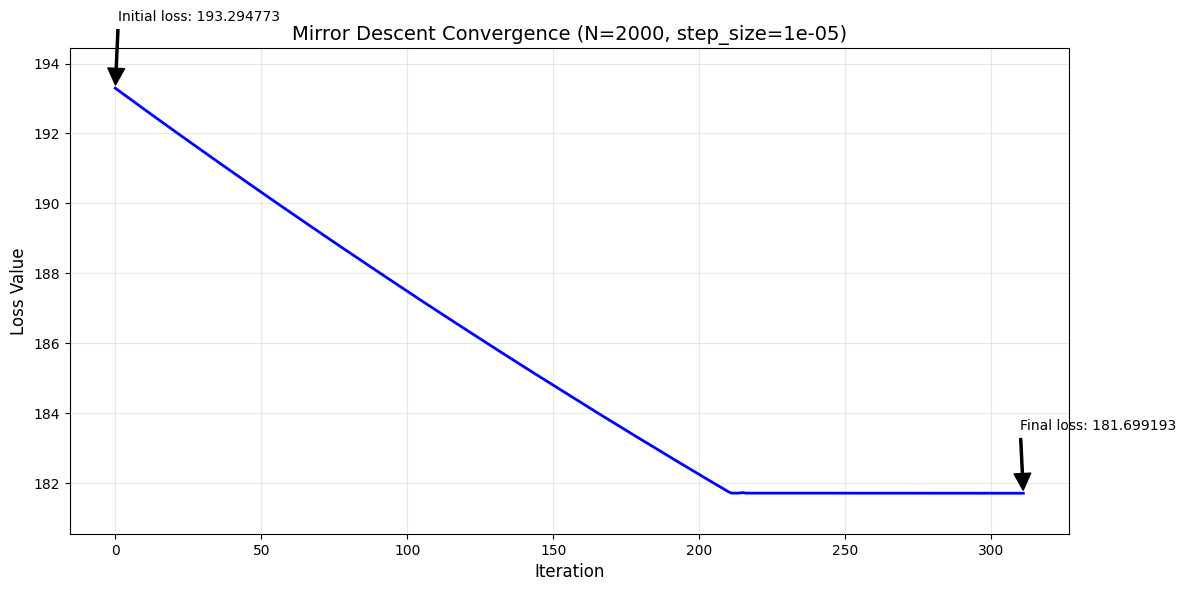

In [5]:
# Extract loss values from log
losses = log_data.get('loss', [])
iterations = range(len(losses))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(iterations, losses, 'b-', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.title(f'Mirror Descent Convergence (N={N}, step_size={step_size})', fontsize=14)

# Set y-axis limits with some margin to avoid extreme stretching
if len(losses) > 0:
    min_loss = min(losses)
    max_loss = max(losses)
    if min_loss != max_loss:
        y_margin = 0.1 * (max_loss - min_loss)
        plt.ylim(min_loss - y_margin, max_loss + y_margin)
    else:
        plt.ylim(min_loss - 1, max_loss + 1)

# Add annotation for final loss
if len(losses) > 1:
    plt.annotate(f'Final loss: {losses[-1]:.6f}', 
                xy=(iterations[-1], losses[-1]),
                xytext=(iterations[-1]-1, losses[-1]*1.01),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Add initial loss annotation
if len(losses) > 0:
    plt.annotate(f'Initial loss: {losses[0]:.6f}', 
                xy=(0, losses[0]),
                xytext=(1, losses[0]*1.01),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.tight_layout()
plt.show()


## Function Behavior Analysis

Let's explore how the function behaves for different parameter values 

Testing p = 0.300…
EMD: 0.7838804796876164
N: 2000, C: 20, p: 0.3, reg: 1.5, reg_m1: 200, reg_m2: 125
Optimization method: Mirror Descent
Iterations: 100
Converged: False
Time taken: 4.5260 seconds
Transport cost:  0.3719247388341615
Regularization term: 2.8196288258749105
Marginal penalty:  157.83246410934234
Marginal penalty normalized:  0.4856383511056687
Final distance:  0.8575630899398302
G sum:  0.9999999999999999
Initial loss: 163.9128190676989
Final loss: 161.0240176740514
Loss reduction: 2.8888013936474977
Testing p = 0.306…
EMD: 0.7513859457251557
N: 2000, C: 20, p: 0.30612244897959184, reg: 1.5, reg_m1: 200, reg_m2: 125
Optimization method: Mirror Descent
Iterations: 100
Converged: False
Time taken: 4.4795 seconds
Transport cost:  0.37048387115661535
Regularization term: 2.8167606225888644
Marginal penalty:  154.88700754925543
Marginal penalty normalized:  0.4765754078438629
Final distance:  0.8470592790004783
G sum:  0.9999999999999999
Initial loss: 160.8665568376247
Final 

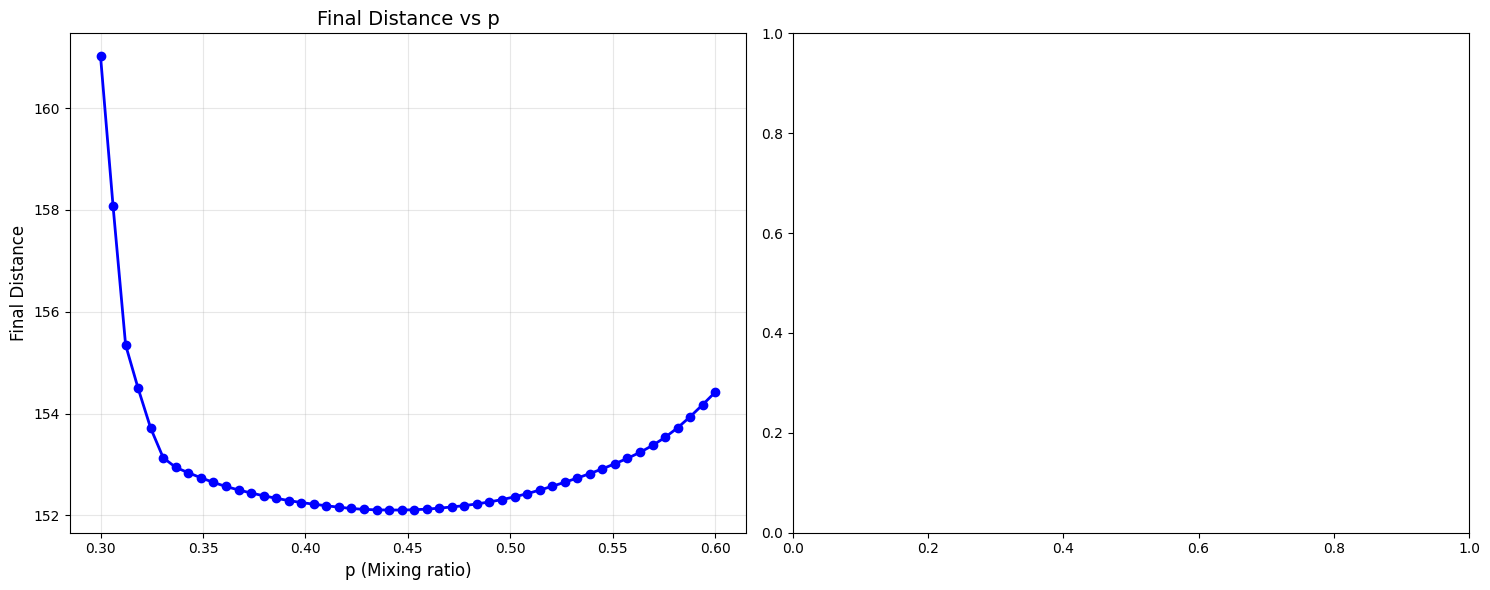


Summary for p values from 0.30 to 0.60:
Final Distance - Min: 152.103868, Max: 161.024018


In [52]:
M = 2 * N
offsets = np.arange(-C + 1, C)
matrix_shape = (M, M)
test_values = np.linspace(0.3, 0.6, 50)
final_distances = []
warm = None  # no warmstart on first run

for test_p in test_values:
    print(f"Testing p = {test_p:.3f}…")

    # 1) run mirror‐descent, passing warm (None or dia_matrix)
    G_data, log = test_sparse_mirror_descent(
        N=N,
        C=C,
        p=test_p,
        reg=reg,
        reg_m1=reg_a,
        reg_m2=reg_b,
        max_iter=max_iter,
        step_size=step_size,
        debug=True,
        warmstart=warm,  # either None or the dia_matrix from last iteration
    )

    # 2) immediately convert the returned padded‐diagonals
    #    into a scipy.sparse.dia_matrix with the correct full shape
    warm = dia_matrix((G_data, offsets), shape=matrix_shape)

    # 3) record your final_distance
    final_distances.append(log["loss"][-1])

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot final distances
ax1.plot(test_values, final_distances, 'bo-', linewidth=2, markersize=6)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('p (Mixing ratio)', fontsize=12)
ax1.set_ylabel('Final Distance', fontsize=12)
ax1.set_title('Final Distance vs p', fontsize=14)


plt.tight_layout()
plt.show()
max_iter
# Print summary statistics
print(f"\nSummary for p values from {min(test_values):.2f} to {max(test_values):.2f}:")
print(f"Final Distance - Min: {min(final_distances):.6f}, Max: {max(final_distances):.6f}")

# WS distance for comparison

Testing function behavior for different p values...
Testing p = 0.300...
Testing p = 0.308...
Testing p = 0.316...
Testing p = 0.324...
Testing p = 0.333...
Testing p = 0.341...
Testing p = 0.349...
Testing p = 0.357...
Testing p = 0.365...
Testing p = 0.373...
Testing p = 0.382...
Testing p = 0.390...
Testing p = 0.398...
Testing p = 0.406...
Testing p = 0.414...
Testing p = 0.422...
Testing p = 0.431...
Testing p = 0.439...
Testing p = 0.447...
Testing p = 0.455...
Testing p = 0.463...
Testing p = 0.471...
Testing p = 0.480...
Testing p = 0.488...
Testing p = 0.496...
Testing p = 0.504...
Testing p = 0.512...
Testing p = 0.520...
Testing p = 0.529...
Testing p = 0.537...
Testing p = 0.545...
Testing p = 0.553...
Testing p = 0.561...
Testing p = 0.569...
Testing p = 0.578...
Testing p = 0.586...
Testing p = 0.594...
Testing p = 0.602...
Testing p = 0.610...
Testing p = 0.618...
Testing p = 0.627...
Testing p = 0.635...
Testing p = 0.643...
Testing p = 0.651...
Testing p = 0.659...
Tes

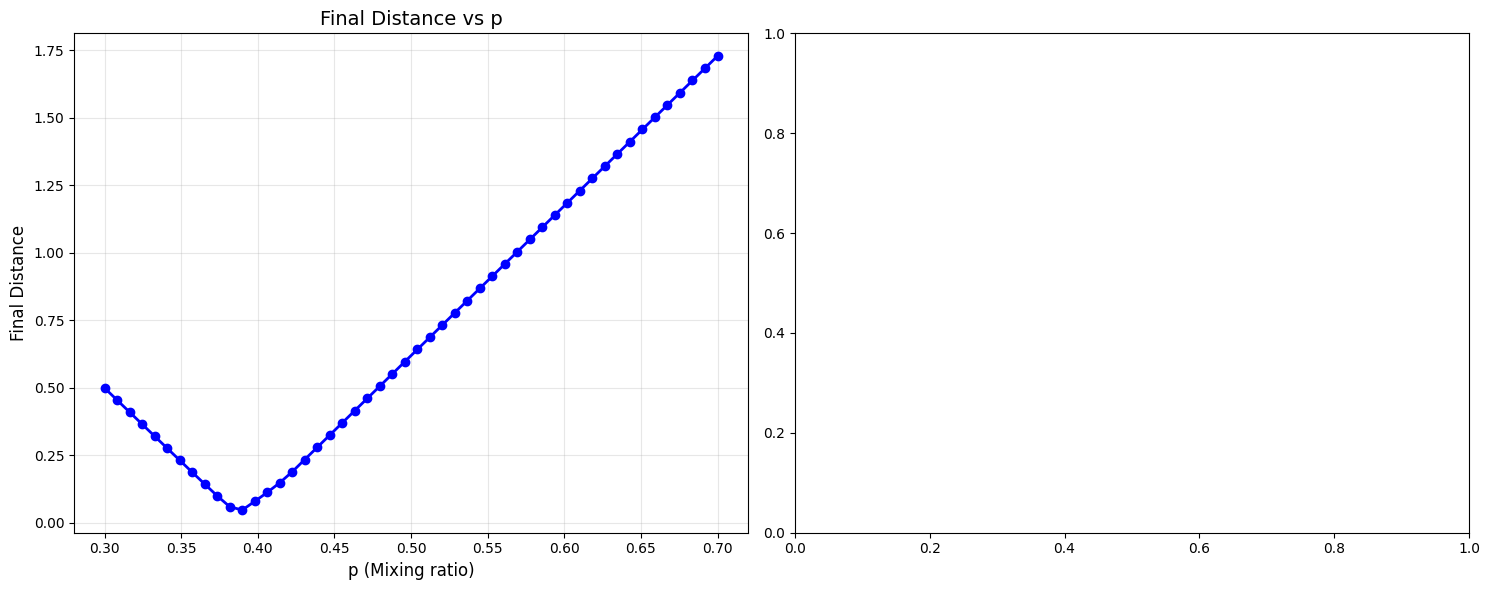


Summary for p values from 0.30 to 0.70:
Final Distance - Min: 0.046347, Max: 1.728680


In [ ]:
# Test function behavior for different p values between 0.3 and 0.7
test_values = np.linspace(0.3, 0.7, 50)  # Test 10 values from 0.3 to 0.7
final_distances = []
final_costs = []
print("Testing function behavior for different p values...")
for test_p in test_values:
    print(f"Testing p = {test_p:.3f}...")

    # Run optimization with current p value
    test = test_ws_distance(
        N,
        C,
        test_p,
        0.01,
        reg_a,
        reg_b,
        max_iter=max_iter,
        step_size=step_size,
        debug=True,
    )

    final_distances.append(test)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot final distances
ax1.plot(test_values, final_distances, "bo-", linewidth=2, markersize=6)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("p (Mixing ratio)", fontsize=12)
ax1.set_ylabel("Final Distance", fontsize=12)
ax1.set_title("Final Distance vs p", fontsize=14)


plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for p values from {min(test_values):.2f} to {max(test_values):.2f}:")
print(
    f"Final Distance - Min: {min(final_distances):.6f}, Max: {max(final_distances):.6f}"
)
